<a href="https://colab.research.google.com/github/poligenius/SiameseNN_HandwrittenRecognition/blob/main/POC_Handwritten_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting Drive
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# HANDWRITTEN COMPARISON



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##  SIAMESE NN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### DEFINING THE NETWORK

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_siamese_network(input_shape):
    # Define the input layer
    input_signature = layers.Input(shape=input_shape)

    # Shared weights for both signature images
    shared_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu')
    ])

    # Encoding for the first signature image
    encoded_signature1 = shared_model(input_signature)

    # Encoding for the second signature image
    input_comparison_signature = layers.Input(shape=input_shape)
    encoded_signature2 = shared_model(input_comparison_signature)

    # L1 distance layer between the two encoded signatures
    l1_distance = layers.Lambda(lambda x: keras.backend.abs(x[0] - x[1]))([encoded_signature1, encoded_signature2])

    # Prediction layer
    prediction = layers.Dense(1, activation='sigmoid')(l1_distance)

    # Create the siamese network
    siamese_network = Model(inputs=[input_signature, input_comparison_signature], outputs=prediction)

    return siamese_network

### PREDICTION FUNCTION
that leverages custom_threshold  
objective: --> minimize the number of false positives towards 0

### MODEL COMPILE

In [ ]:
# Define the input shape of signature images
input_shape = (200, 200, 3)

# Create the siamese network
siamese_net = create_siamese_network(input_shape)

# Compile the model
siamese_net.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  7563916   ['input_1[0][0]',             
                                                          8          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 256)                  0         ['sequential[0][0]',      

### TRAIN


In [ ]:
import os
import random

# Path to the directory containing images
base_path = '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train'

# Function to generate pairs and labels
def generate_pairs_and_labels(base_path):
    pairs = []
    labels = []

    for number_folder in os.listdir(base_path):
        if number_folder.startswith('_') or number_folder.endswith('_forg'):  # Skip folders starting with underscore
            continue

        genuine_folder = os.path.join(base_path, number_folder)
        forgery_folder = os.path.join(base_path, f"{number_folder}_forg")

        genuine_images = os.listdir(genuine_folder)
        forgery_images = os.listdir(forgery_folder)

        for genuine_image in genuine_images:
            genuine_image_path = os.path.join(genuine_folder, genuine_image)
            forgery_image_path = os.path.join(forgery_folder, random.choice(forgery_images))

            pairs.append((genuine_image_path, forgery_image_path))
            labels.append(1)  # Label 1 for fake pairs

            # Creating mismatched pairs
            mismatch_genuine_image_path = os.path.join(genuine_folder, random.choice(genuine_images))
            pairs.append((genuine_image_path, mismatch_genuine_image_path))
            labels.append(0)  # Label 0 for genuine pairs

    return pairs, labels

# Generate pairs and labels
pairs, labels = generate_pairs_and_labels(base_path)

# Display the first few pairs and their labels
for pair, label in zip(pairs[:5], labels[:5]):
    print(f"Pair: {pair}, Label: {label}")


Pair: ('/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_20.PNG', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002_forg/0108002_01.png'), Label: 1
Pair: ('/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_20.PNG', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_14.PNG'), Label: 0
Pair: ('/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_22.PNG', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002_forg/0110002_04.png'), Label: 1
Pair: ('/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_22.PNG', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_21.PNG'), Label: 0
Pair: ('/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002/002_09.PNG', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/train/002_forg/0110002_02.png'), Label: 1


In [ ]:
# Train the model
# Convert image pairs to NumPy arrays
import cv2
import numpy as np

def preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize the images to the required dimensions
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Preprocess the image pairs
pair1_paths, pair2_paths = zip(*pairs)
pair1_images = preprocess_images(pair1_paths)
pair2_images = preprocess_images(pair2_paths)


Epoch 1/10
45/45 [==============================] - 581s 13s/step - loss: 0.7126 - accuracy: 0.4961 - val_loss: 0.6787 - val_accuracy: 0.6282
Epoch 2/10
45/45 [==============================] - 568s 13s/step - loss: 0.6315 - accuracy: 0.5208 - val_loss: 0.5485 - val_accuracy: 0.7380
Epoch 3/10
45/45 [==============================] - 567s 13s/step - loss: 0.5101 - accuracy: 0.7815 - val_loss: 0.5583 - val_accuracy: 0.8761
Epoch 4/10
45/45 [==============================] - 563s 13s/step - loss: 0.3923 - accuracy: 0.8541 - val_loss: 0.4279 - val_accuracy: 0.9268
Epoch 5/10
45/45 [==============================] - 563s 13s/step - loss: 0.2882 - accuracy: 0.9006 - val_loss: 0.4026 - val_accuracy: 0.9380
Epoch 6/10
45/45 [==============================] - 570s 13s/step - loss: 0.2251 - accuracy: 0.9253 - val_loss: 0.3913 - val_accuracy: 0.9465
Epoch 7/10
45/45 [==============================] - 569s 13s/step - loss: 0.1530 - accuracy: 0.9570 - val_loss: 0.3909 - val_accuracy: 0.9155
Epoch 

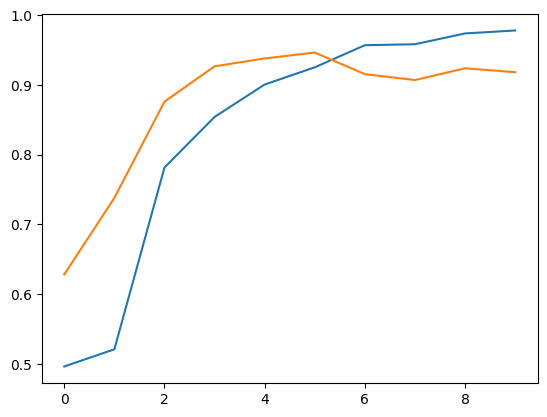

In [ ]:
import matplotlib.pyplot as plt

# Convert labels to NumPy array
labels_array = np.array(labels)

# Train the Siamese network
history = siamese_net.fit([pair1_images, pair2_images], labels_array, batch_size=32, epochs=10, validation_split=0.2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
siamese_net.save('/content/drive/MyDrive/Colab Notebooks/POC_Handwritten_model')

### TEST CASE

In [ ]:
# load model
from tensorflow.keras.models import load_model

siamese_net = load_model("/content/drive/MyDrive/Colab Notebooks/POC_Handwritten_model")

#### firme della stessa persona

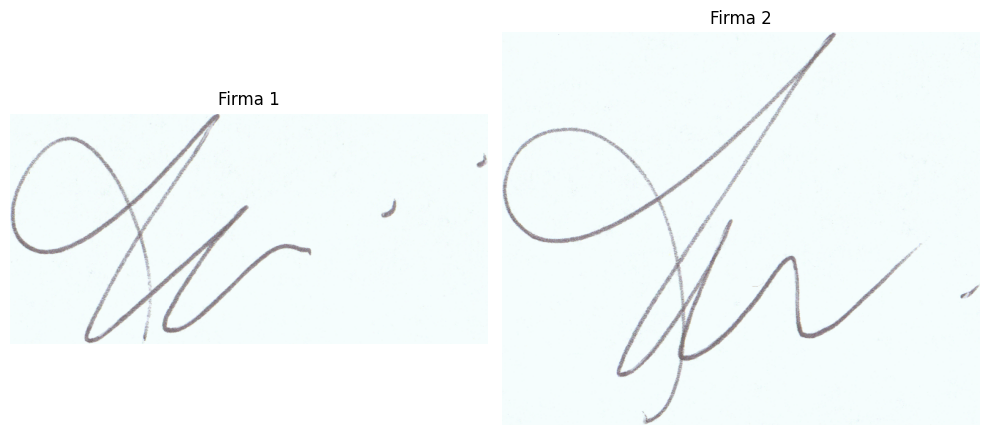

1/1 [==============================] - 0s 146ms/step
le firme sono della stessa persona
confidence:  [0.40128255]


In [ ]:
# Assuming 'siamese_net' is your trained model
import cv2
import matplotlib.pyplot as plt


# Function to preprocess test images
def preprocess_test_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize the images to the required dimensions
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Test image paths
test_image_paths = ['/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/049/01_049.png', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/049/04_049.png']  # Replace with your test image paths

# Preprocess the test images
test_images = preprocess_test_images(test_image_paths)


# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (img_path, img) in enumerate(zip(test_image_paths, test_images)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with Matplotlib
    axes[i].imshow(img)
    axes[i].set_title(f"Firma {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Make predictions
predicted_probabilities = siamese_net.predict([test_images[0].reshape(1, 200, 200, 3), test_images[1].reshape(1, 200, 200, 3)])

if (predicted_probabilities[0] < 0.5):
  print("le firme sono della stessa persona")
else:
  print("la firma 2 è falsificata")

print("confidence: ", predicted_probabilities[0])


#### firme di persone diverse

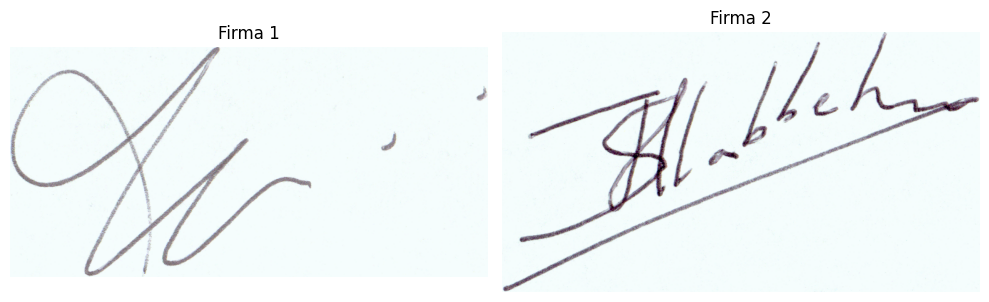

1/1 [==============================] - 0s 161ms/step
la firma 2 è falsificata
confidence:  [1.]


In [ ]:
# Assuming 'siamese_net' is your trained model
import cv2
import matplotlib.pyplot as plt


# Function to preprocess test images
def preprocess_test_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize the images to the required dimensions
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Test image paths
test_image_paths = ['/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/049/01_049.png', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/050_forg/01_0125050.PNG']  # Replace with your test image paths

# Preprocess the test images
test_images = preprocess_test_images(test_image_paths)


# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (img_path, img) in enumerate(zip(test_image_paths, test_images)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with Matplotlib
    axes[i].imshow(img)
    axes[i].set_title(f"Firma {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Make predictions
predicted_probabilities = siamese_net.predict([test_images[0].reshape(1, 200, 200, 3), test_images[1].reshape(1, 200, 200, 3)])

if (predicted_probabilities[0] < 0.5):
  print("le firme sono della stessa persona")
else:
  print("la firma 2 è falsificata")

print("confidence: ", predicted_probabilities[0])


#### stessa firma falsificata

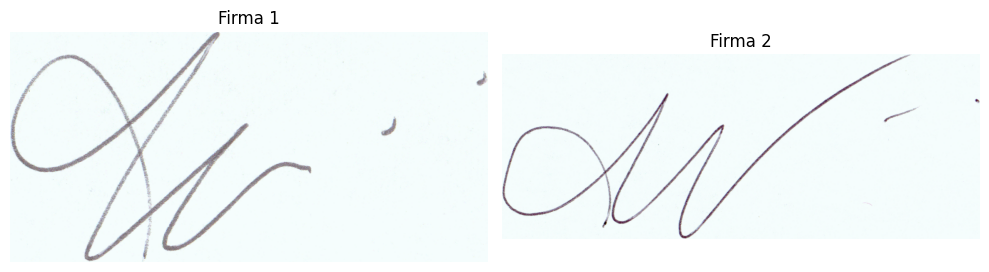

1/1 [==============================] - 0s 132ms/step
la firma 2 è falsificata
confidence:  [0.9998098]


In [ ]:
# Assuming 'siamese_net' is your trained model
import cv2
import matplotlib.pyplot as plt


# Function to preprocess test images
def preprocess_test_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize the images to the required dimensions
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Test image paths
test_image_paths = ['/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/049/01_049.png', '/content/drive/MyDrive/Colab Notebooks/dati_firme/sign_data/test/049_forg/02_0210049.PNG']
# Preprocess the test images
test_images = preprocess_test_images(test_image_paths)


# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (img_path, img) in enumerate(zip(test_image_paths, test_images)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with Matplotlib
    axes[i].imshow(img)
    axes[i].set_title(f"Firma {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Make predictions
predicted_probabilities = siamese_net.predict([test_images[0].reshape(1, 200, 200, 3), test_images[1].reshape(1, 200, 200, 3)])

if (predicted_probabilities[0] < 0.5):
  print("le firme sono della stessa persona")
else:
  print("la firma 2 è falsificata")

print("confidence: ", predicted_probabilities[0])


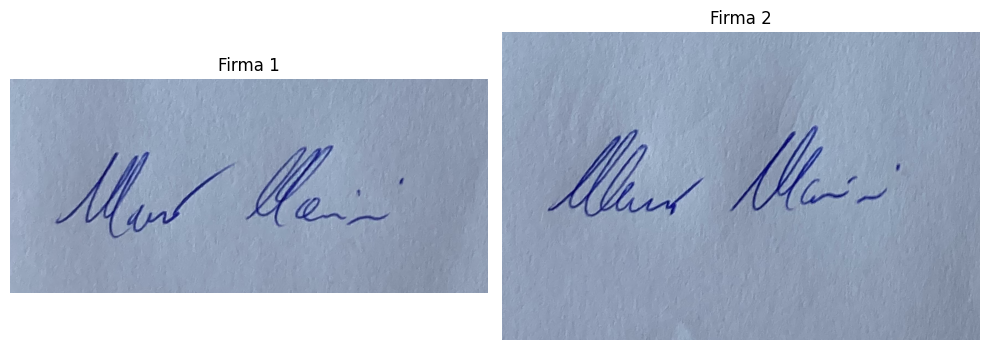

1/1 [==============================] - 0s 183ms/step
la firma 2 è falsificata
confidence:  [0.8163483]


In [ ]:
# Assuming 'siamese_net' is your trained model
import cv2
import matplotlib.pyplot as plt


# Function to preprocess test images
def preprocess_test_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (200, 200))  # Resize the images to the required dimensions
        img = img.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
        images.append(img)
    return np.array(images)

# Test image paths
test_image_paths = ['/content/2.png', '/content/2b.png']
# Preprocess the test images
test_images = preprocess_test_images(test_image_paths)


# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (img_path, img) in enumerate(zip(test_image_paths, test_images)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with Matplotlib
    axes[i].imshow(img)
    axes[i].set_title(f"Firma {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Make predictions
predicted_probabilities = siamese_net.predict([test_images[0].reshape(1, 200, 200, 3), test_images[1].reshape(1, 200, 200, 3)])

if (predicted_probabilities[0] < 0.5):
  print("le firme sono della stessa persona")
else:
  print("la firma 2 è falsificata")

print("confidence: ", predicted_probabilities[0])
